# Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'REST1'      : {'runs': [1,2]},
    'REST2'      : {'runs': [3,4]},
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],
                    'task': ['0bk', '2bk'],
                    'cond': ['body','faces','places','tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
SUBJECTS = range(N_SUBJECTS)

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [4]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [6]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
REGION_INFO = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [7]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (dict of dict of lists): A list of frames associated with each condition

  """
  frames_dict = {t : {} for t in EXPERIMENTS[experiment]['task']}
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for task in EXPERIMENTS[experiment]['task']:
    for cond in EXPERIMENTS[experiment]['cond']:    
      ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{task}_{cond}.txt"
      ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
      ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
      # Determine when trial starts, rounded down
      start = np.floor(ev["onset"] / TR).astype(int)
      # Use trial duration to determine how many frames to include for trial
      duration = np.ceil(ev["duration"] / TR).astype(int)
      # Take the range of frames that correspond to this specific trial
      frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
      frames_dict[task][cond] = frames

  return frames_dict

def load_task_results(subject, experiment, run):
  """Load results data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    [corr, err] (dict of lists): A list of frames associated with each result

  """
  corr_dict = {}
  err_dict = {}
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for task in EXPERIMENTS[experiment]['task']:
    corr_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{task}_cor.txt"
    if os.stat(corr_file).st_size > 0:
      corr_array = np.loadtxt(corr_file, ndmin=2, unpack=True)
    else:
      corr_array = np.array([[]])
    # Determine time stamps
    corr_frames = np.floor(corr_array[0, :] / TR).astype(int)

    err_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{task}_err.txt"
    if os.stat(err_file).st_size > 0:
      err_array = np.loadtxt(err_file, ndmin=2, unpack=True)
    else:
      err_array = np.array([[]])
    # Determine time stamps
    err_frames = np.floor(err_array[0, :] / TR).astype(int)

    corr_dict[task] = corr_frames
    err_dict[task] = err_frames

  return [corr_dict, err_dict]

def merge_task_data(data, evs, results, task):
  """Merge the data for all the conditions within a task.

  Args:
    data: the raw timeseries data for all tasks
    evs: the explanatory variables for the task
    results: the results for the task
    task: the task for which to merge all the data

  Returns
    (data, evs, [corr, err]): the subset of data, EVs, and correct/error results

  """
  evs = evs[task]
  tframes = np.concatenate(tuple(evs.values())).flatten()
  corr, err = results

  # min_t = np.min(trange)
  # max_t = np.max(trange)

  return np.squeeze(data[:, tframes]), evs, [corr[task], err[task]]

def load_task_data(subject, experiment, run, task, remove_mean = False):
  data = load_single_timeseries(subject, experiment, run, remove_mean)
  evs = load_evs(subject, experiment, run)
  results = load_task_results(subject, experiment, run)

  return merge_task_data(data, evs, results, task)

def map_across_trials(metric, experiment, subjects, runs = [0, 1], remove_mean = False):
  values = []
  for s in subjects:
    run_values = 0
    for r in runs:
      data = load_single_timeseries(subject = s,
                                    experiment = experiment,
                                    run = r,
                                    remove_mean = remove_mean)
      rest_data = load_single_timeseries(subject = s,
                                         experiment = 'REST1',
                                         run = r,
                                         remove_mean = remove_mean)
      evs = load_evs(subject = s, experiment = experiment, run = r)
      results = load_task_results(subject = s, experiment = experiment, run = r)

      run_values += metric(data, rest_data, evs, results)
    values.append(run_values / len(runs))

  return values

def average_across_trials(metric, experiment, subjects, runs = [0, 1], remove_mean = False):
  x = map_across_trials(metric, experiment, subjects, runs, remove_mean)

  return np.mean(np.stack(x), axis=0)

# Data Filtering Technique

In [8]:
def remove_drift(data):
  T = data.shape[1]
  avg_signal = np.mean(data, axis=0).T
  X = np.column_stack((np.arange(T), np.ones(T)))
  w = np.linalg.inv(X.T @ X) @ X.T @ avg_signal
  drift = w[0] * np.arange(T) + w[1]
  
  return data - drift, w

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [9]:
my_exp  = 'WM'
my_rest = 'REST1'
my_subj = 6
my_run  = 0

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=False)
rest_data = load_single_timeseries(subject=my_subj,experiment=my_rest,run=my_run,remove_mean=False)
print(data.shape)
print(rest_data.shape)

(360, 405)
(360, 1200)


In [10]:
data[0, 0]

10340.7

In [11]:
load_task_data(my_subj, my_exp, my_run, '2bk')[0].shape[1] * TR

112.32

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [12]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
len(evs['2bk']['body'][0]) * TR * len(EXPERIMENTS[my_exp]['cond'])

112.32

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [13]:
# we need a little function that averages all frames from any given condition
def average_rest_frames(data):
  return np.mean(data, axis=1)

def average_frames(data, evs, experiment, task, cond):    
  evs_task = evs[task][cond]

  return np.mean(np.squeeze(data[:, evs_task]), axis=1)


faces_2bk_activity = average_frames(data, evs, my_exp, '2bk', 'faces')
rest_activity = average_rest_frames(rest_data)
contrast    = faces_2bk_activity-rest_activity   # difference between left and right hand movement

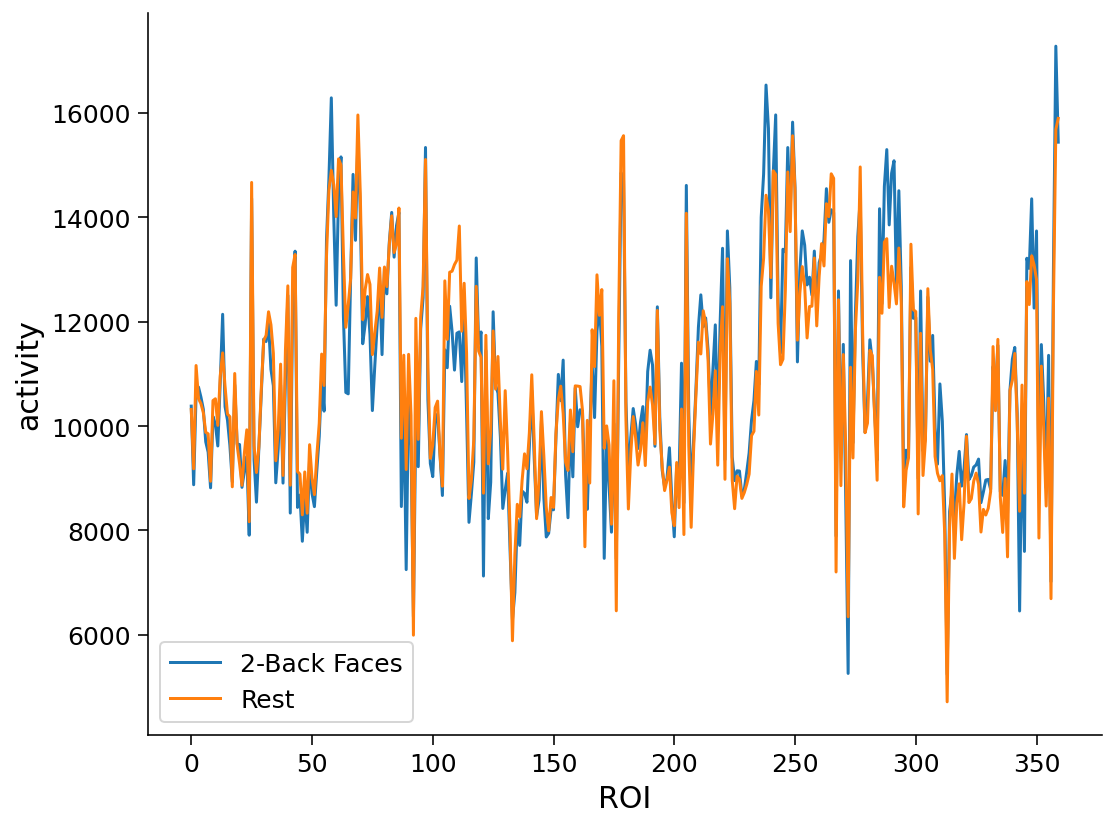

In [14]:
# Plot activity level in each ROI for both conditions
plt.plot(faces_2bk_activity, label='2-Back Faces')
plt.plot(rest_activity, label='Rest')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





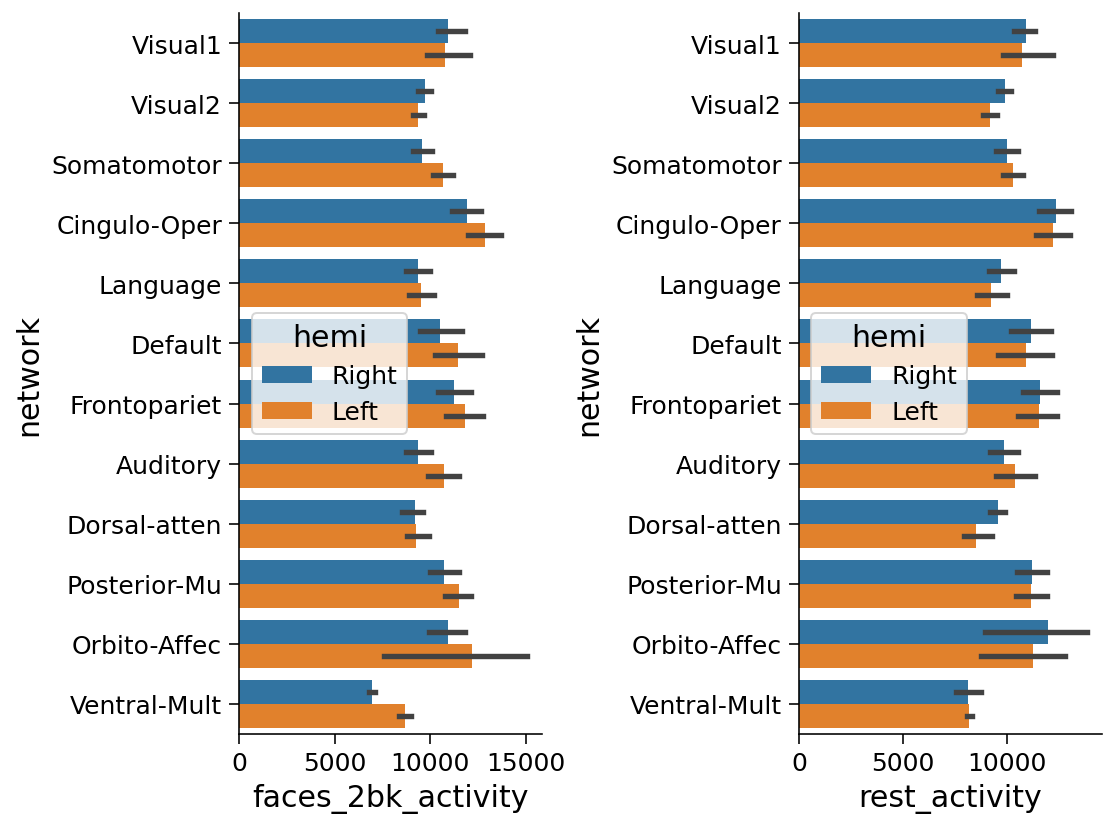

In [15]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'faces_2bk_activity' : faces_2bk_activity,
                   'rest_activity' : rest_activity,
                   'network'     : REGION_INFO['network'],
                   'hemi'        : REGION_INFO['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='faces_2bk_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rest_activity', data=df, hue='hemi',ax=ax2)

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be suubtle at the single subject/session level (these are a quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [16]:
group_contrast = average_across_trials(
    lambda data, rdata, evs, results: \
      average_frames(data, evs, my_exp, '2bk', 'faces') - average_rest_frames(rdata),
    my_exp,
    SUBJECTS
)

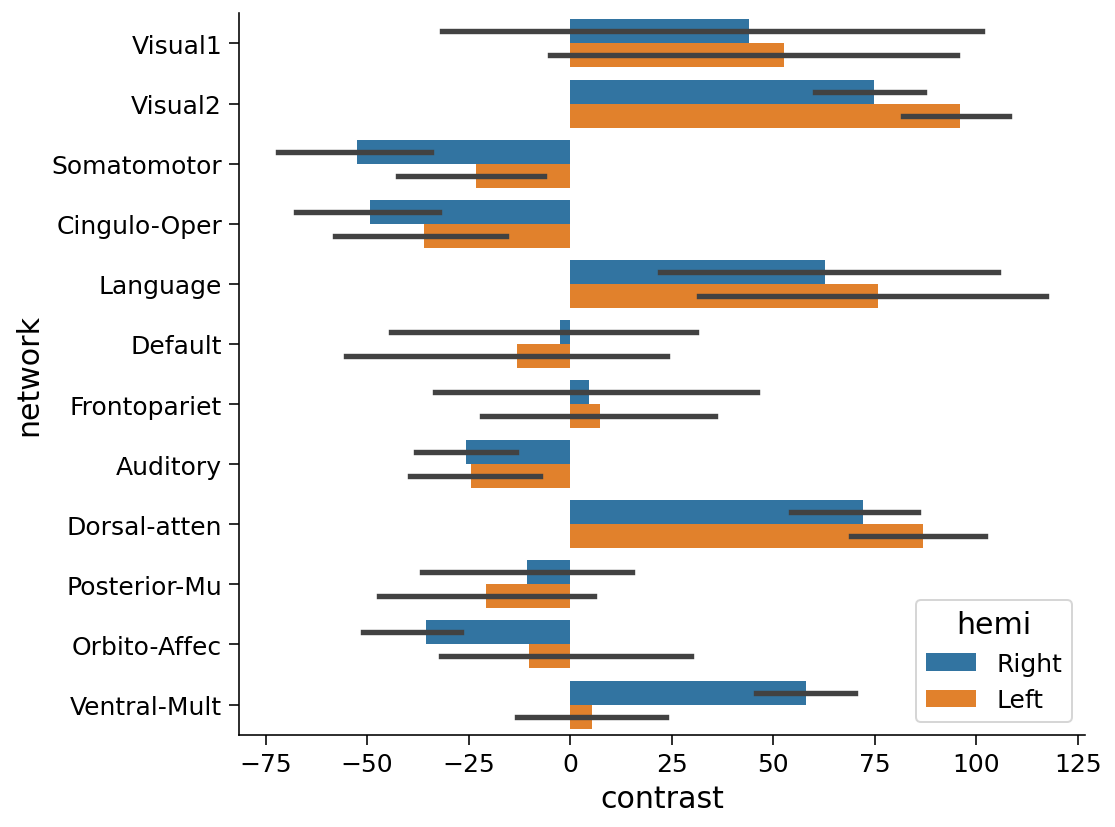

In [17]:
df = pd.DataFrame({'contrast': group_contrast,
                   'network': REGION_INFO['network'],
                   'hemi': REGION_INFO['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')

# Task Accuracy

Text(0.5, 0, 'Accuracy')

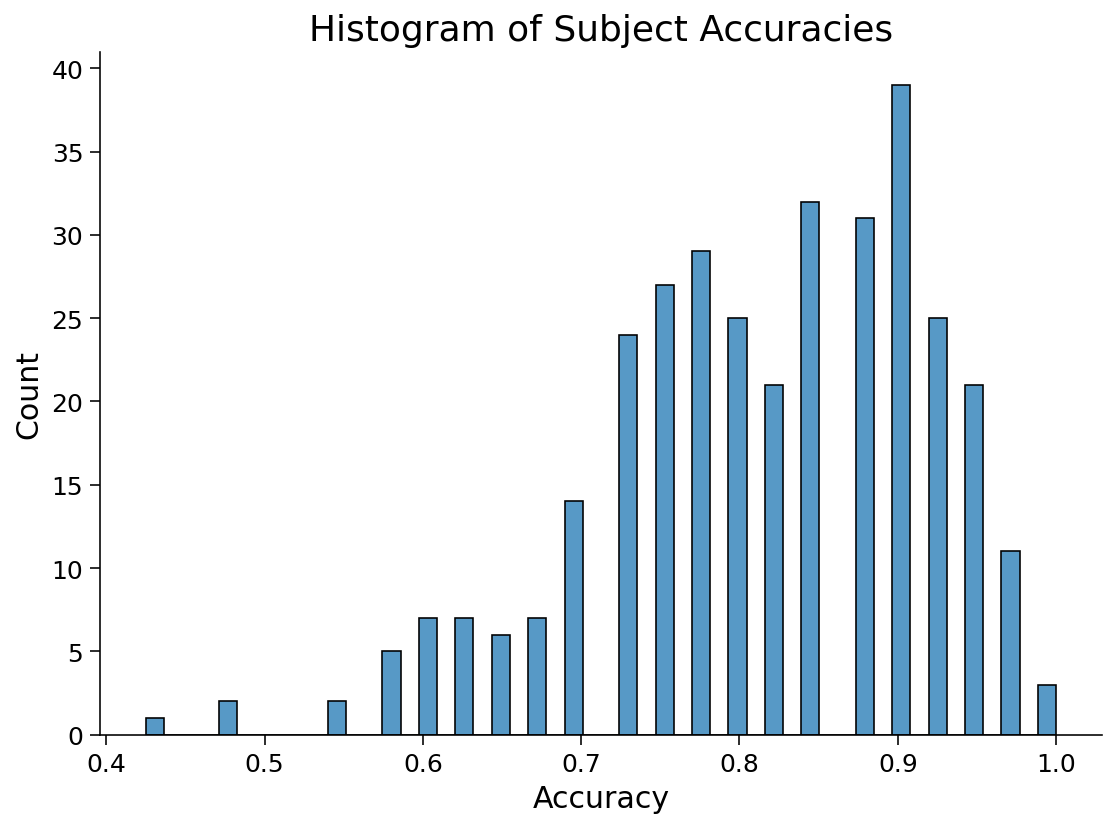

In [18]:
def get_task_accuracy(results, task):
  corr, err = results

  return len(corr[task]) / (len(corr[task]) + len(err[task]))

def get_subj_accuracy(subject, experiment, run, task):
  results = load_task_results(subject, experiment, run)

  return get_task_accuracy(results, task)

subj_accuracy = np.array([get_subj_accuracy(s, my_exp, my_run, '2bk') for s in SUBJECTS])

ax = sns.histplot(subj_accuracy, bins=50)
ax.title.set_text('Histogram of Subject Accuracies')
ax.xaxis.set_label_text('Accuracy')

# Correlation calculations

In [21]:
def get_corr(data):
  corr = np.corrcoef(data)
  np.fill_diagonal(corr, 0)

  return corr

def get_rest_corr(data):
  return get_corr(data)

def get_task_corr(data, evs, task, cond = None):
  dummy_results = [{task: []}, {task: []}] # to make merge_task_data okay
  if cond is None:
    data = merge_task_data(data, evs, dummy_results, task)[0]
  else:
    data = np.squeeze(data[:, evs[task][cond]])

  return get_corr(data)

def normalize_corr(corr):
  return (corr - np.mean(corr)) / np.std(corr)

def prune_corr(corr, rate, binarize = False):
  upper = np.triu(corr,k=1).flatten()
  upper = upper[upper != 0]
  p = np.percentile(upper, 100 - rate)
  if binarize:
    return np.where(corr >= p, 1, 0)
  else:
    return np.where(corr >= p, corr, 0)

def corr_similarity(corr1,corr2):
  ut_idx = np.triu_indices(corr1.shape[0],k=1)
  sim = np.corrcoef(corr1[ut_idx],corr2[ut_idx])
  return sim[0,1]

rest_corr = get_rest_corr(rest_data)
faces_2bk_corr = get_task_corr(data, evs, '2bk', 'faces')
print(rest_corr.shape)
print(faces_2bk_corr.shape)

(360, 360)
(360, 360)


In [22]:
np.mean(prune_corr(rest_corr, 20) == rest_corr)

0.20222222222222222

In [20]:
np.unique(REGION_INFO['network'])

array(['Auditory', 'Cingulo-Oper', 'Default', 'Dorsal-atten',
       'Frontopariet', 'Language', 'Orbito-Affec', 'Posterior-Mu',
       'Somatomotor', 'Ventral-Mult', 'Visual1', 'Visual2'], dtype='<U12')

In [23]:
REGIONS = ['Frontopariet', 'Dorsal-atten', 'Default']

def get_region_idxs(region_info, region):
  return np.where(region_info['network'] == region)[0]

def get_corr_subset(corr, region_info, region):
  idx = get_region_idxs(region_info, region)
  return corr[np.ix_(idx, idx)]

all_idxs = np.concatenate([get_region_idxs(REGION_INFO, region) for region in REGIONS])
for region in REGIONS:
  print(region, ':', len(get_region_idxs(REGION_INFO, region)))

Frontopariet : 50
Dorsal-atten : 7
Default : 23


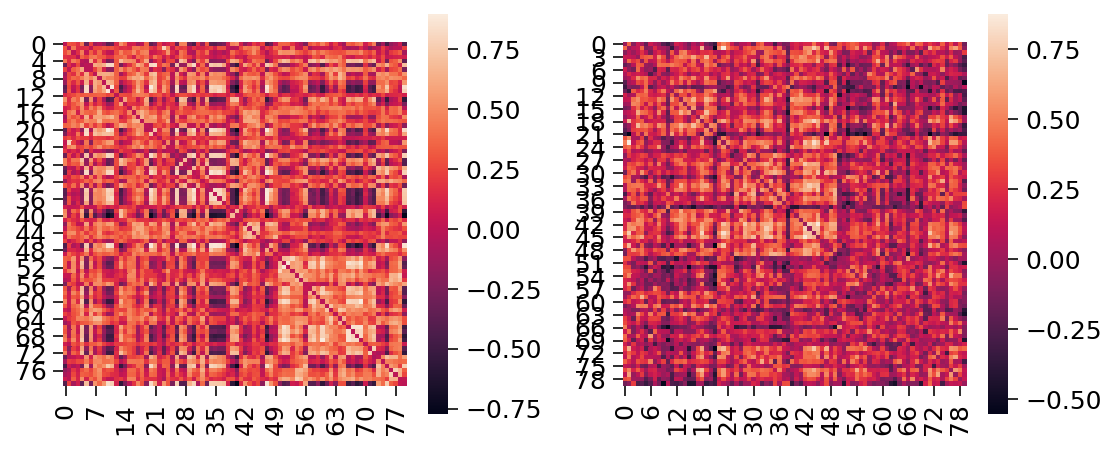

In [24]:
fig,(ax1,ax2) = plt.subplots(1,2)
sns.heatmap(rest_corr[np.ix_(all_idxs, all_idxs)], ax=ax1, square=True, cbar_kws={'shrink': 0.5})
sns.heatmap(faces_2bk_corr[np.ix_(all_idxs, all_idxs)], ax=ax2, square=True, cbar_kws={'shrink': 0.5})

# Sparsifying matrices

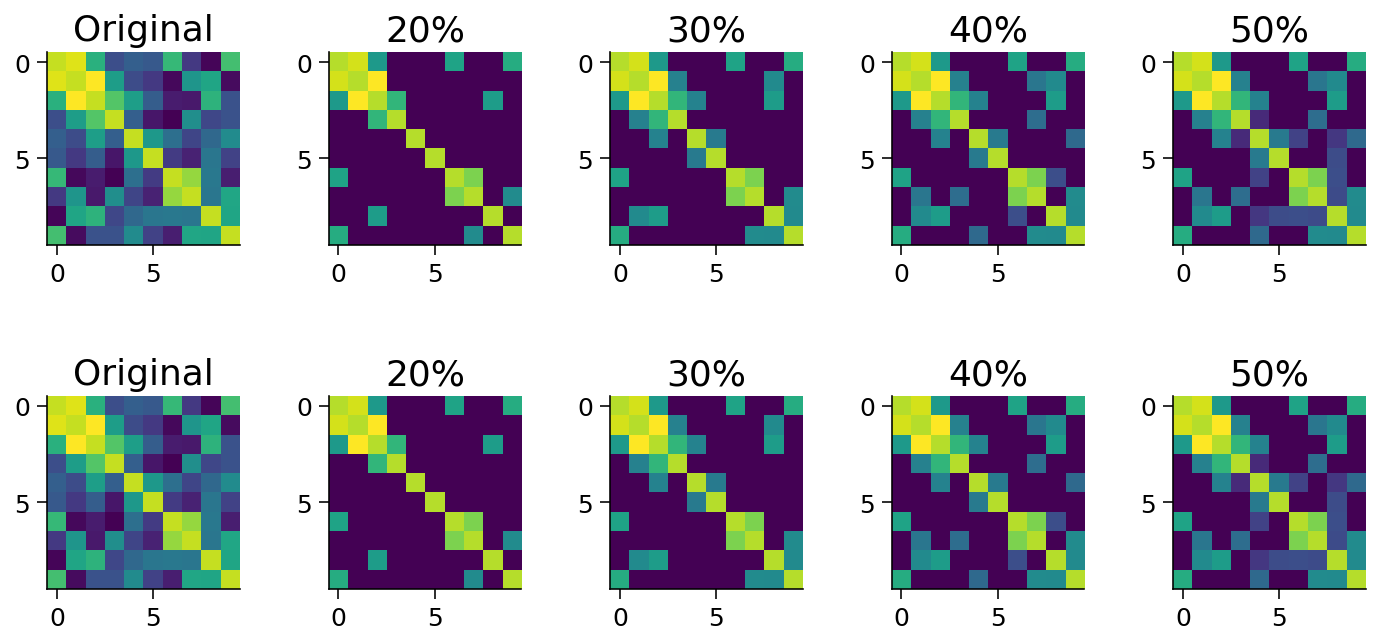

In [25]:
A = np.random.rand(10,10)-0.3
A = np.tril(A,k=1) + np.tril(A,k=1).T
np.fill_diagonal(A,1)

# 
def prune_corr2(corr, rate, binarize = False):
  upper = np.triu(corr,k=1).flatten()
  upper = upper[upper != 0]
  p = np.percentile(upper, 100 - rate)
  if binarize:
    return np.where(corr >= p, 1, 0)
  else:
    return np.where(corr >= p, corr, 0)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(251)
ax2 = fig.add_subplot(252)
ax3 = fig.add_subplot(253)
ax4 = fig.add_subplot(254)
ax5 = fig.add_subplot(255)
ax6 = fig.add_subplot(256)
ax7 = fig.add_subplot(257)
ax8 = fig.add_subplot(258)
ax9 = fig.add_subplot(259)
ax10 = fig.add_subplot(2,5,10)


ax1.imshow(A)
ax1.title.set_text('Original')
ax2.imshow(prune_corr(A,20))
ax2.title.set_text('20%')
ax3.imshow(prune_corr(A,30))
ax3.title.set_text('30%')
ax4.imshow(prune_corr(A,40))
ax4.title.set_text('40%')
ax5.imshow(prune_corr(A,50))
ax5.title.set_text('50%')

ax6.imshow(A)
ax6.title.set_text('Original')
ax7.imshow(prune_corr2(A,20))
ax7.title.set_text('20%')
ax8.imshow(prune_corr2(A,30))
ax8.title.set_text('30%')
ax9.imshow(prune_corr2(A,40))
ax9.title.set_text('40%')
ax10.imshow(prune_corr2(A,50))
ax10.title.set_text('50%')

In [26]:
print(np.mean(prune_corr(A,20) ==0))
print(np.mean(prune_corr2(A,20) ==0))

0.72
0.72


In [27]:
N = 10
0.2*(N*N/2 - N)

8.0

In [28]:
rest_corr

array([[ 0.        ,  0.64502223,  0.48796455, ..., -0.01117803,
         0.2466624 , -0.12333617],
       [ 0.64502223,  0.        ,  0.61708001, ..., -0.02843875,
         0.08324922, -0.22437393],
       [ 0.48796455,  0.61708001,  0.        , ...,  0.18071733,
         0.2676193 ,  0.15556511],
       ...,
       [-0.01117803, -0.02843875,  0.18071733, ...,  0.        ,
         0.52065179,  0.44842562],
       [ 0.2466624 ,  0.08324922,  0.2676193 , ...,  0.52065179,
         0.        ,  0.49352815],
       [-0.12333617, -0.22437393,  0.15556511, ...,  0.44842562,
         0.49352815,  0.        ]])

In [29]:
rest_corr.flatten()

array([0.        , 0.64502223, 0.48796455, ..., 0.44842562, 0.49352815,
       0.        ])

# Graphs

In [30]:
!pip install python-igraph --quiet
import igraph

     |████████████████████████████████| 3.2 MB 4.1 MB/s 


In [31]:
def make_graph(corr):
  g = igraph.Graph.Weighted_Adjacency(corr, mode='undirected', loops=False)

  return g

rest_graph = make_graph(rest_corr)
rest_graph.summary()

'IGRAPH U-W- 360 64620 -- \n+ attr: weight (e)'

In [32]:
def nodal_eff(g):
  weights = np.abs(1.0 / np.array(g.es["weight"][:]))
  sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
  np.fill_diagonal(sp,0)
  N=sp.shape[0]
  ne = (1.0 / (N - 1)) * np.sum(sp, axis=0)

  return ne

def avg_eff(g):
  return np.mean(nodal_eff(g))

def global_eff(g):
  N = g.vcount()
  fc_g = make_graph(np.ones((N, N)))

  return avg_eff(g) / avg_eff(fc_g)

print(avg_eff(rest_graph))
print(global_eff(rest_graph))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.37910258365782534
0.37910258365782534


In [33]:
fpcn_idxs = get_region_idxs(REGION_INFO, 'Frontopariet')
fpcn_rest_graph = make_graph(rest_corr[np.ix_(fpcn_idxs, fpcn_idxs)])
fpcn_2bk_faces_graph = make_graph(faces_2bk_corr[np.ix_(fpcn_idxs, fpcn_idxs)])
print(global_eff(fpcn_2bk_faces_graph) - global_eff(fpcn_rest_graph))
print(subj_accuracy[my_subj])

-0.03046278286546006
0.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


# Results

In [34]:
def regression_plot(x,y, ax):
  regresults = scipy.stats.linregress(x,y)
  xrange = np.arange(np.min(x),np.max(x),0.001)
  yrange = regresults.slope*xrange + regresults.intercept
  ax.plot(xrange,yrange,linewidth=5,color='k')
  ax.text(np.max(x),np.max(y),f"r={regresults.rvalue}\np={regresults.pvalue}",horizontalalignment='right',verticalalignment='top')

## Delta Efficiency

In [35]:
subj_corr_2bk_rest = map_across_trials(
    lambda data, rdata, evs, results: \
      np.array([get_task_corr(remove_drift(data)[0], evs, '2bk'), 
                get_rest_corr(remove_drift(rdata)[0])]),
    my_exp,
    SUBJECTS,
    remove_mean = True
  )

g_task = {region: 
            [make_graph(
                get_corr_subset(subj_corr_2bk_rest[s][0, :, :],
                                REGION_INFO, region)) for s in SUBJECTS]
          for region in REGIONS}
g_rest = {region: 
            [make_graph(
                get_corr_subset(subj_corr_2bk_rest[s][1, :, :],
                                REGION_INFO, region)) for s in SUBJECTS]
          for region in REGIONS}

global_eff_task = {region: np.array([global_eff(g) for g in gs]) for region, gs in g_task.items()}
global_eff_rest = {region: np.array([global_eff(g) for g in gs]) for region, gs in g_rest.items()}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


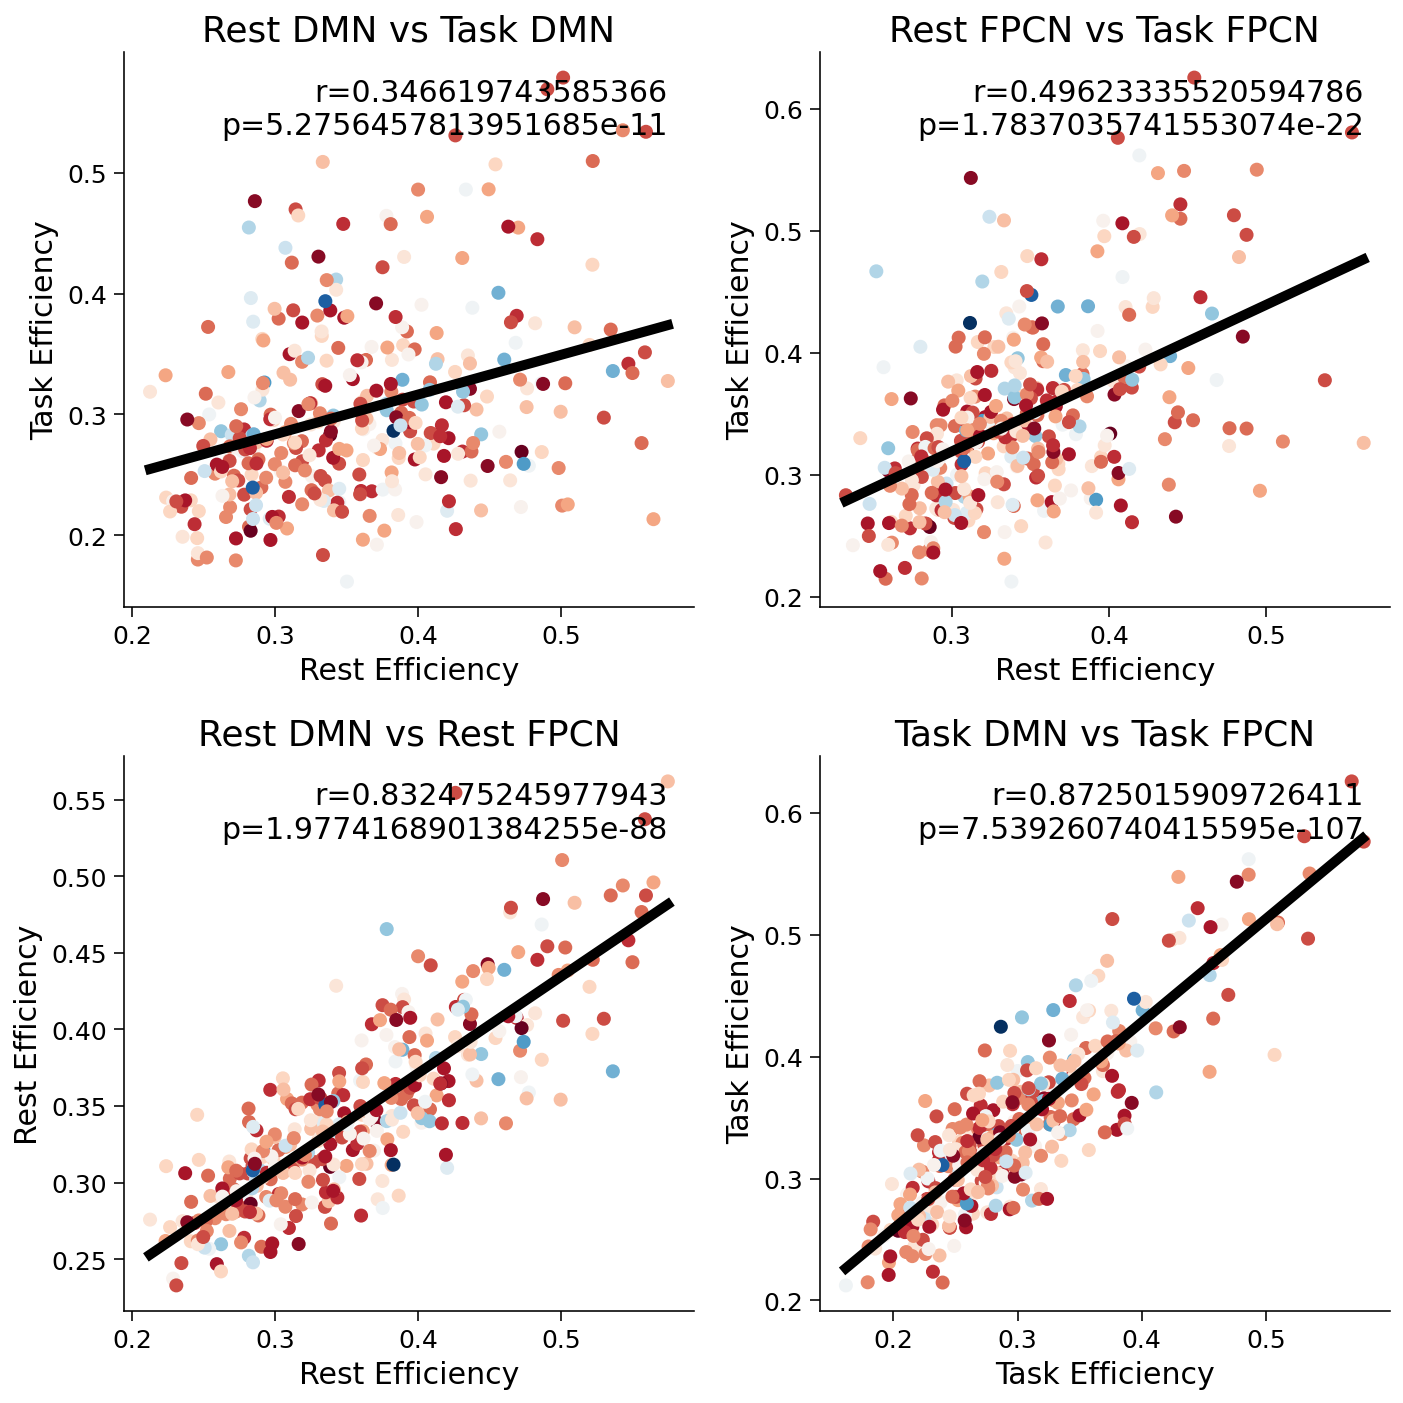

In [36]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(global_eff_rest['Default'], global_eff_task['Default'],c=subj_accuracy,cmap='RdBu_r')
ax1.title.set_text('Rest DMN vs Task DMN')
ax1.xaxis.set_label_text('Rest Efficiency')
ax1.yaxis.set_label_text('Task Efficiency')
regression_plot(global_eff_rest['Default'], global_eff_task['Default'],ax1)
ax2.scatter(global_eff_rest['Frontopariet'], global_eff_task['Frontopariet'],c=subj_accuracy,cmap='RdBu_r')
ax2.title.set_text('Rest FPCN vs Task FPCN')
ax2.xaxis.set_label_text('Rest Efficiency')
ax2.yaxis.set_label_text('Task Efficiency')
regression_plot(global_eff_rest['Frontopariet'], global_eff_task['Frontopariet'],ax2)
ax3.scatter(global_eff_rest['Default'], global_eff_rest['Frontopariet'],c=subj_accuracy,cmap='RdBu_r')
ax3.title.set_text('Rest DMN vs Rest FPCN')
ax3.xaxis.set_label_text('Rest Efficiency')
ax3.yaxis.set_label_text('Rest Efficiency')
regression_plot(global_eff_rest['Default'], global_eff_rest['Frontopariet'],ax3)
ax4.scatter(global_eff_task['Default'], global_eff_task['Frontopariet'],c=subj_accuracy,cmap='RdBu_r')
ax4.title.set_text('Task DMN vs Task FPCN')
ax4.xaxis.set_label_text('Task Efficiency')
ax4.yaxis.set_label_text('Task Efficiency')
regression_plot(global_eff_task['Default'], global_eff_task['Frontopariet'],ax4)

In [37]:
global_eff_diff = {region: global_eff_task[region] - global_eff_rest[region] for region in REGIONS}

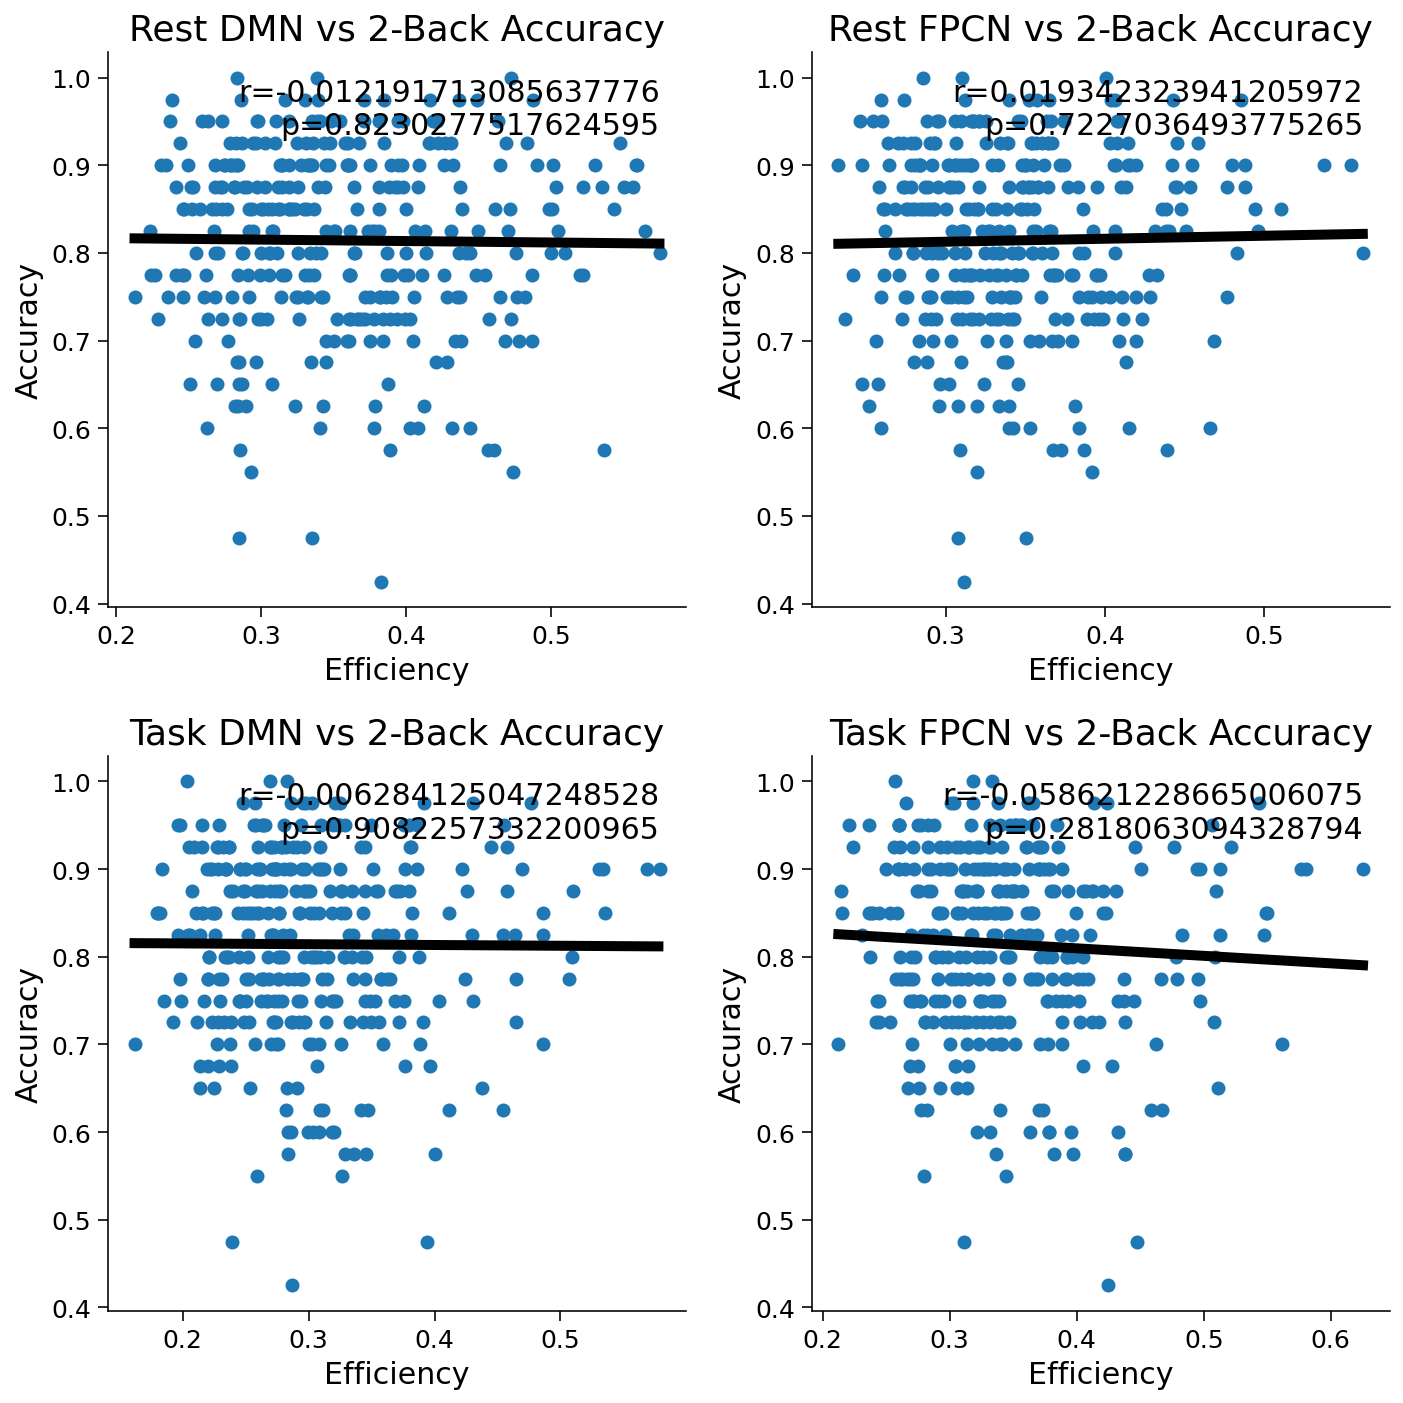

In [38]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(global_eff_rest['Default'], subj_accuracy)
ax1.title.set_text('Rest DMN vs 2-Back Accuracy')
ax1.xaxis.set_label_text('Efficiency')
ax1.yaxis.set_label_text('Accuracy')
regression_plot(global_eff_rest['Default'], subj_accuracy,ax1)
ax2.scatter(global_eff_rest['Frontopariet'], subj_accuracy)
ax2.title.set_text('Rest FPCN vs 2-Back Accuracy')
ax2.xaxis.set_label_text('Efficiency')
ax2.yaxis.set_label_text('Accuracy')
regression_plot(global_eff_rest['Frontopariet'], subj_accuracy,ax2)
ax3.scatter(global_eff_task['Default'], subj_accuracy)
ax3.title.set_text('Task DMN vs 2-Back Accuracy')
ax3.xaxis.set_label_text('Efficiency')
ax3.yaxis.set_label_text('Accuracy')
regression_plot(global_eff_task['Default'], subj_accuracy,ax3)
ax4.scatter(global_eff_task['Frontopariet'], subj_accuracy)
ax4.title.set_text('Task FPCN vs 2-Back Accuracy')
ax4.xaxis.set_label_text('Efficiency')
ax4.yaxis.set_label_text('Accuracy')
regression_plot(global_eff_task['Frontopariet'], subj_accuracy,ax4)

(array([  2.,   7.,  15.,  35.,  95., 111.,  45.,  21.,   5.,   3.]),
 array([-0.23602694, -0.18931187, -0.14259679, -0.09588172, -0.04916664,
        -0.00245157,  0.0442635 ,  0.09097858,  0.13769365,  0.18440873,
         0.2311238 ]),
 <a list of 10 Patch objects>)

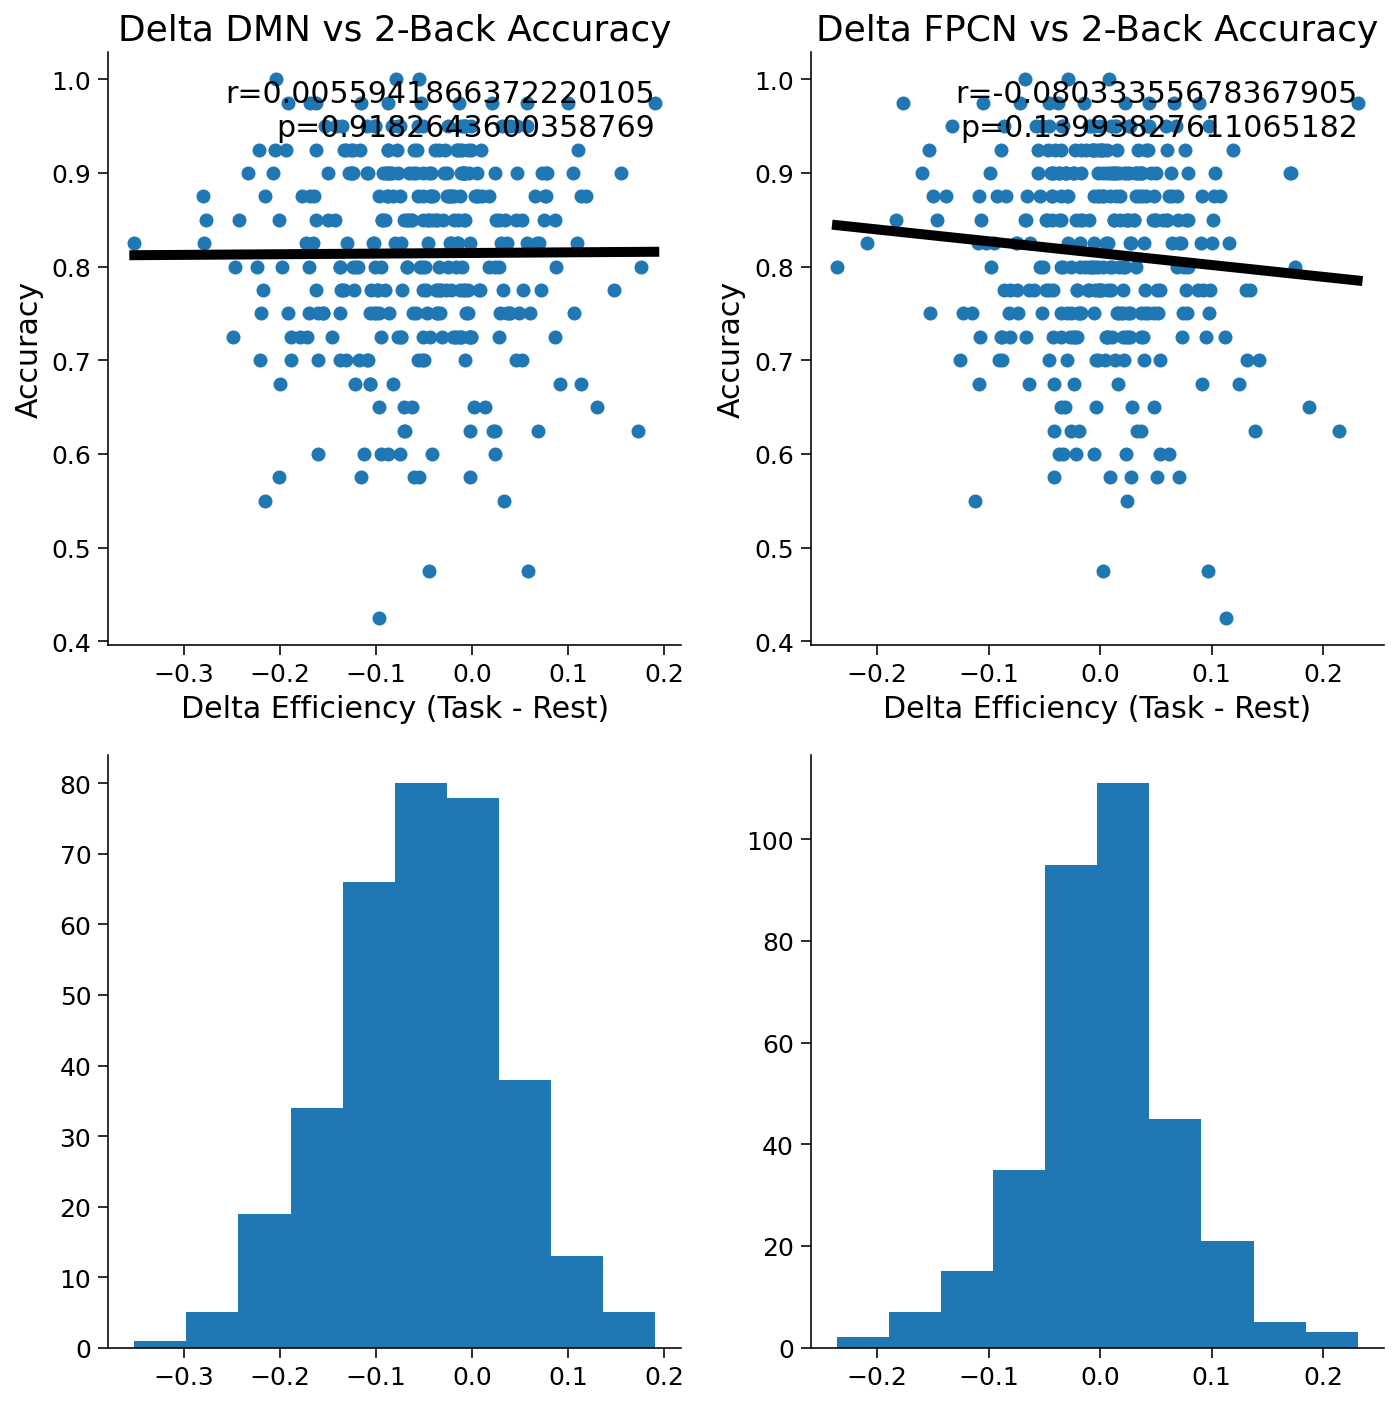

In [40]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(global_eff_diff['Default'], subj_accuracy,)
regression_plot(global_eff_diff['Default'], subj_accuracy,ax1)
ax1.title.set_text('Delta DMN vs 2-Back Accuracy')
ax1.xaxis.set_label_text('Delta Efficiency (Task - Rest)')
ax1.yaxis.set_label_text('Accuracy')
ax2.scatter(global_eff_diff['Frontopariet'], subj_accuracy)
regression_plot(global_eff_diff['Frontopariet'], subj_accuracy,ax2)
ax2.title.set_text('Delta FPCN vs 2-Back Accuracy')
ax2.xaxis.set_label_text('Delta Efficiency (Task - Rest)')
ax2.yaxis.set_label_text('Accuracy')
ax3.hist(global_eff_diff['Default'])
ax4.hist(global_eff_diff['Frontopariet'])

## Similarity Analysis

In [41]:
sim_matrices = {region:
                np.array([[corr_similarity(get_corr_subset(subj_corr_2bk_rest[s1][0, :, :], REGION_INFO, region),
                                           get_corr_subset(subj_corr_2bk_rest[s2][0, :, :], REGION_INFO, region))
                  for s1 in np.argsort(subj_accuracy)] for s2 in np.argsort(subj_accuracy)])
                for region in REGIONS}

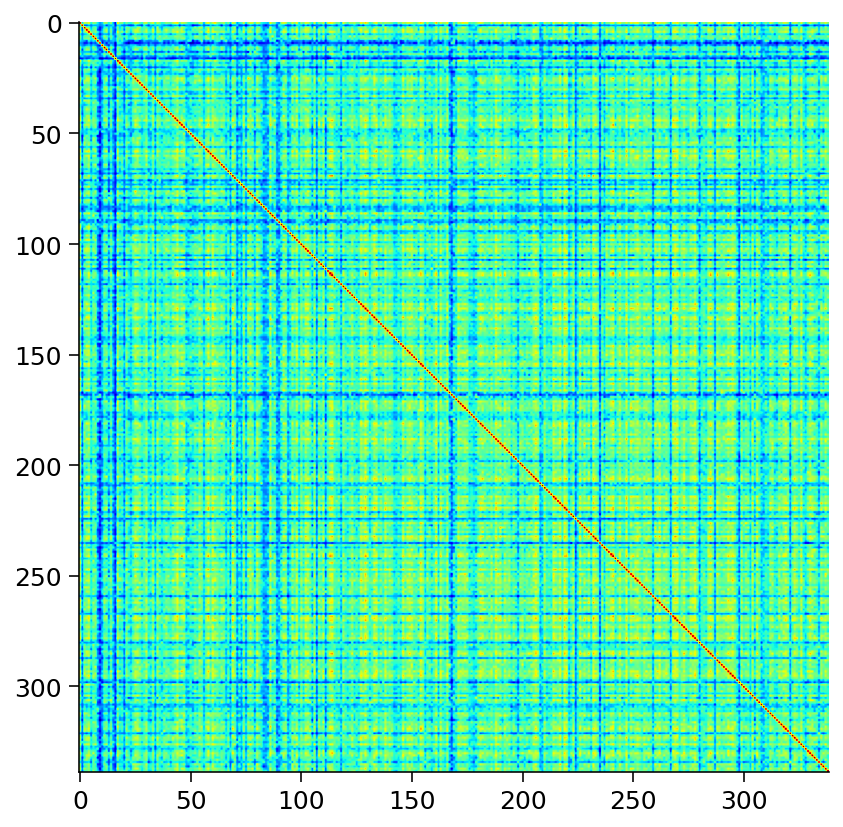

In [42]:
plt.imshow(sim_matrices['Frontopariet'], cmap='jet')

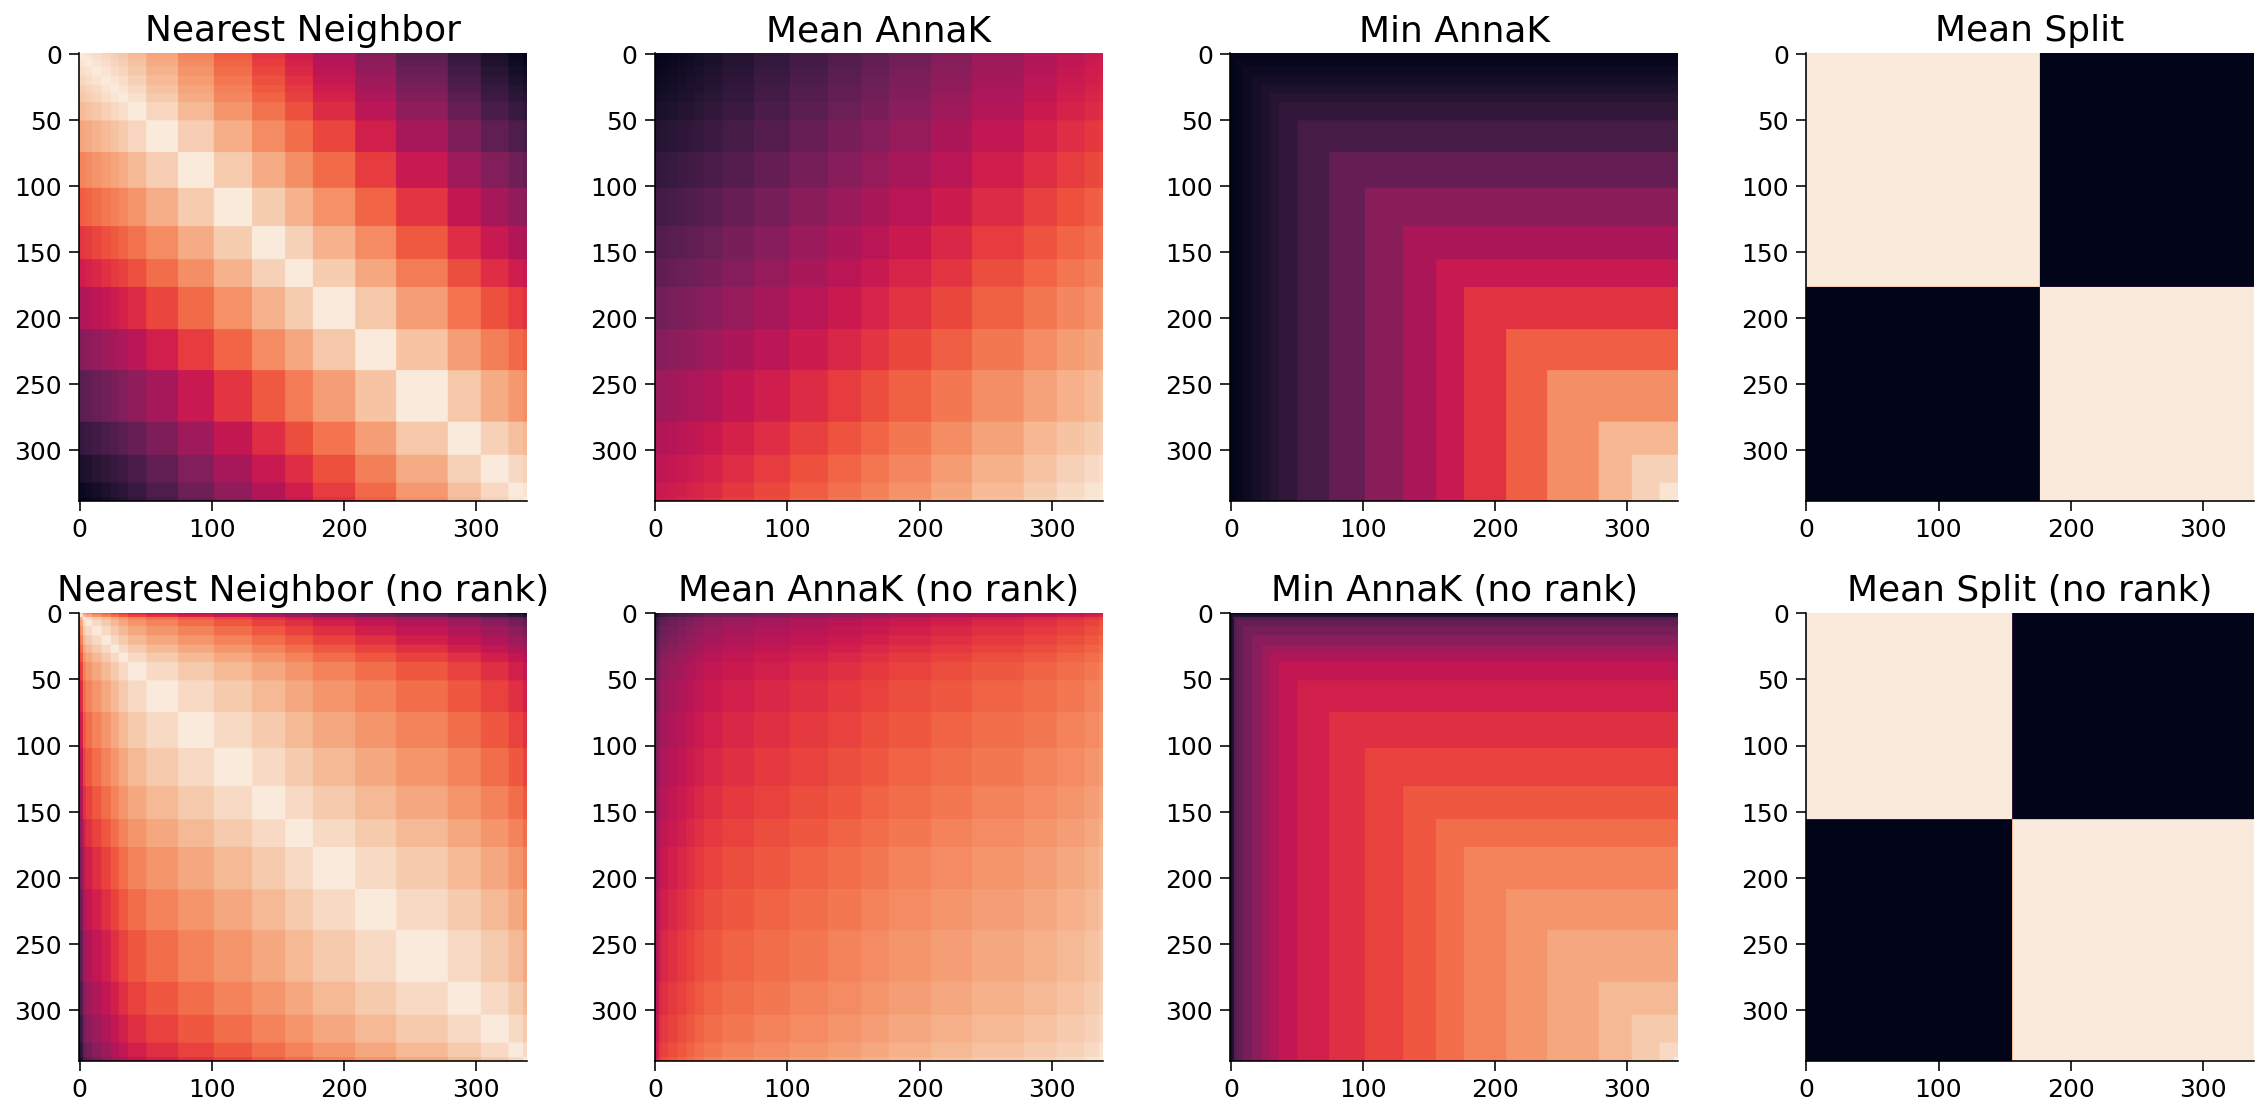

In [99]:
def threshold_similarity(x, y, threshold):
  return 1 - ((x < threshold)^(y < threshold))

def euclidean_similarity(x, y):
  return 1 - np.sqrt((x - y) ** 2)

def annak_similarity(x, y, n, mode = 'mean'):
  if mode == 'mean':
    return np.mean([x, y]) / n
  elif mode == 'min':
    return np.minimum(x, y) / n

def make_rdm(data, distance = euclidean_similarity, by_rank = True):
  if by_rank:
    data = scipy.stats.rankdata(data)
  
  sorted = np.sort(data)
  rdm = np.array([[distance(i, j) for i in sorted] for j in sorted])

  return rdm

rdm_nn = make_rdm(subj_accuracy)
rdm_split = make_rdm(subj_accuracy,
                     lambda i, j: threshold_similarity(i, j, np.median(np.arange(N_SUBJECTS))))
rdm_ak_mean = make_rdm(subj_accuracy,
                       lambda i, j: annak_similarity(i, j, N_SUBJECTS))
rdm_ak_min = make_rdm(subj_accuracy,
                      lambda i, j: annak_similarity(i, j, N_SUBJECTS, 'min'))

unrank_rdm_nn = make_rdm(subj_accuracy, by_rank=False)
unrank_rdm_split = make_rdm(subj_accuracy,
                            lambda i, j: threshold_similarity(i, j, np.median(subj_accuracy)), by_rank=False)
unrank_rdm_ak_mean = make_rdm(subj_accuracy,
                              lambda i, j: annak_similarity(i, j, N_SUBJECTS), by_rank=False)
unrank_rdm_ak_min = make_rdm(subj_accuracy,
                             lambda i, j: annak_similarity(i, j, N_SUBJECTS, 'min'), by_rank=False)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs[0][0].imshow(rdm_nn, cmap='rocket')
axs[0][0].set_title("Nearest Neighbor")
axs[0][1].imshow(rdm_ak_mean, cmap='rocket')
axs[0][1].set_title("Mean AnnaK")
axs[0][2].imshow(rdm_ak_min, cmap='rocket')
axs[0][2].set_title("Min AnnaK")
axs[0][3].imshow(rdm_split, cmap='rocket')
axs[0][3].set_title("Mean Split")
axs[1][0].imshow(unrank_rdm_nn, cmap='rocket')
axs[1][0].set_title("Nearest Neighbor (no rank)")
axs[1][1].imshow(unrank_rdm_ak_mean, cmap='rocket')
axs[1][1].set_title("Mean AnnaK (no rank)")
axs[1][2].imshow(unrank_rdm_ak_min, cmap='rocket')
axs[1][2].set_title("Min AnnaK (no rank)")
axs[1][3].imshow(unrank_rdm_split, cmap='rocket')
axs[1][3].set_title("Mean Split (no rank)");

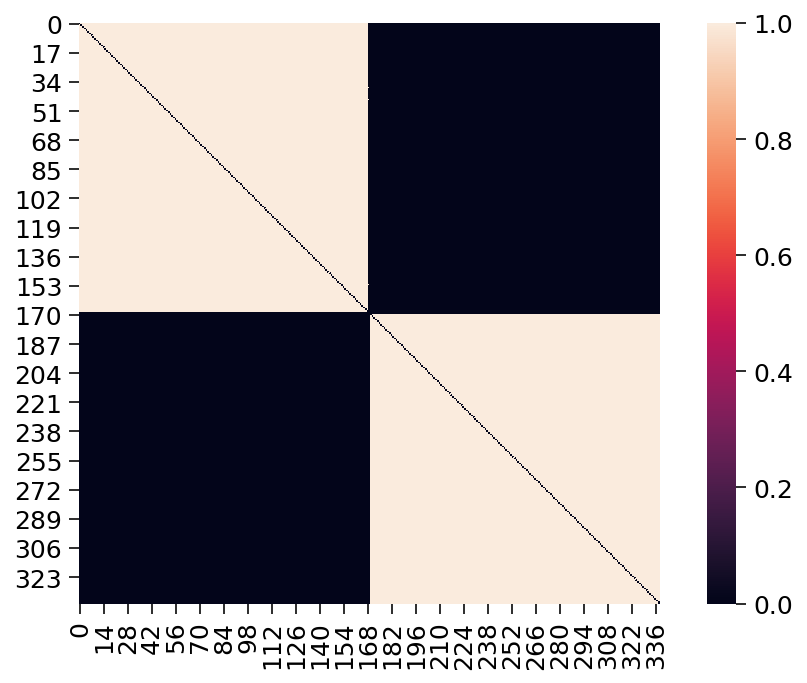

In [ ]:
# what's the split -- median?
# behav_sim_split = np.zeros((n_subs, n_subs))
# behav_sim_split
# for i in range(n_subs):
#     for j in range (n_subs):
#         if i < 169 and j < 169:
#             sim_ij = 1
#             behav_sim_split[i,j] = sim_ij
#             behav_sim_split[j,i] = sim_ij
#         if i > 169 and j > 169:
#             sim_ij = 1
#             behav_sim_split[i,j] = sim_ij
#             behav_sim_split[j,i] = sim_ij 


# behav_sim_split
# pd.DataFrame(behav_sim_split)
# behav_sim_split = Adjacency(behav_sim_split)
# behav_sim_split.plot()
# split = behav_sim_split.squareform()

In [104]:
def correlate_rdms(rdm1, rdm2, mode = 'pearson'):
  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]
  
  if mode == 'pearson':
    r, p =  scipy.stats.pearsonr(rdm1_offdiag, rdm2_offdiag)
  elif mode == 'spearman':
    r, p =  scipy.stats.spearmanr(rdm1_offdiag, rdm2_offdiag)

  return r, p

In [105]:
behav_models = {'NN': rdm_nn,
                'split': rdm_split,
                'ak mean': rdm_ak_mean,
                'ak_min': rdm_ak_min}

unrank_behav_models = {'NN': unrank_rdm_nn,
                       'split': unrank_rdm_split,
                       'ak mean': unrank_rdm_ak_mean,
                       'ak_min': unrank_rdm_ak_min}

In [120]:
rdm_corrs = {region: {label: correlate_rdms(sim_matrices[region], rdm)
             for label, rdm in behav_models.items()} for region in REGIONS}
unrank_rdm_corrs = {region: {label: correlate_rdms(sim_matrices[region], rdm)
                    for label, rdm in unrank_behav_models.items()} for region in REGIONS}

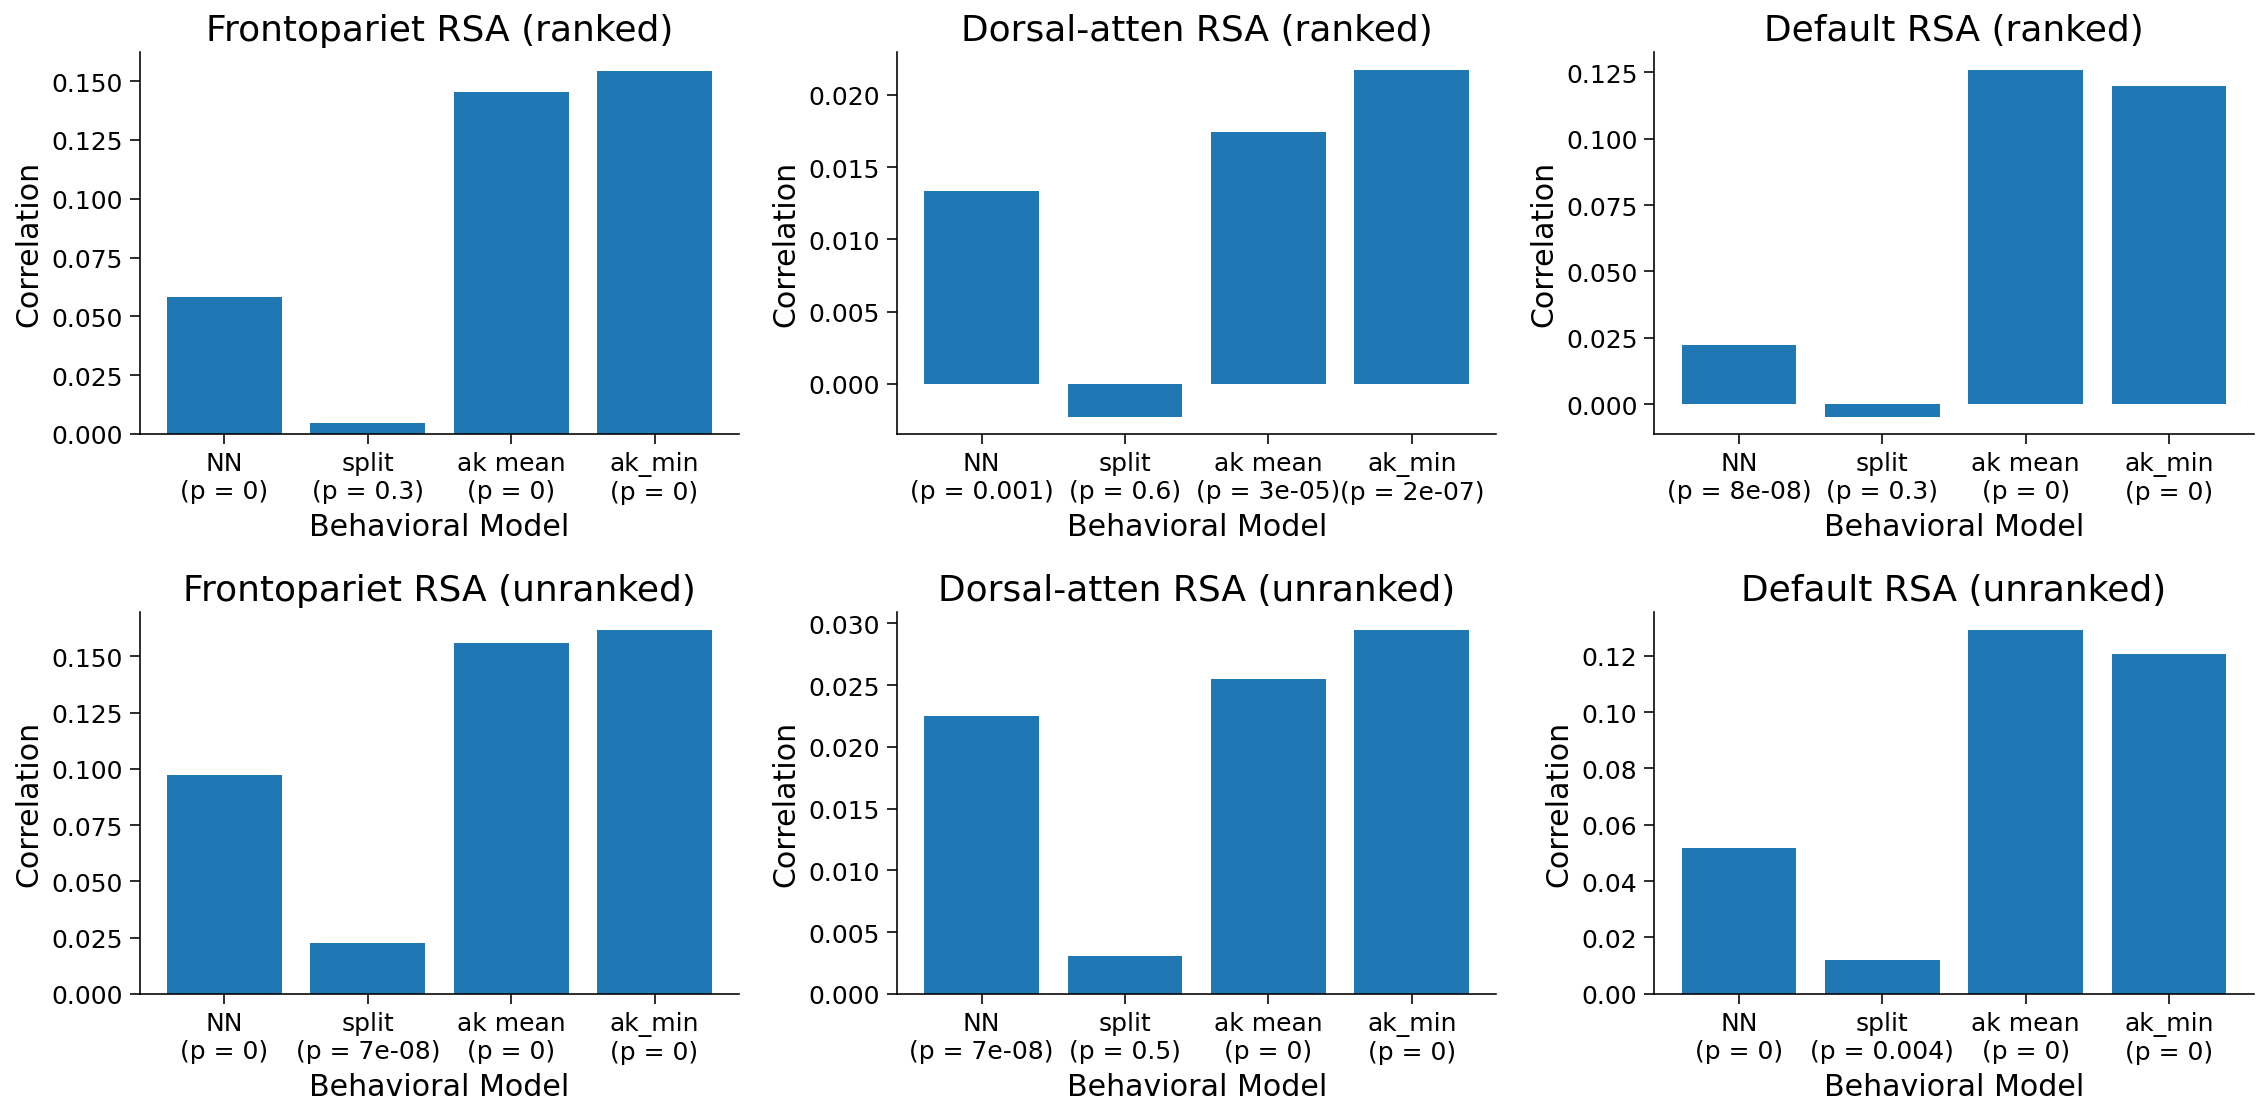

In [121]:
def plot_rdm_rdm_correlations(rdms, ax):
  """Draw a bar plot showing between-RDM correlations."""
  models = rdms.keys()
  rs = [r for r, p in rdms.values()]
  ps = [p if p > 1e-8 else 0 for r, p in rdms.values()]
  labels = [f"{m}\n(p = {p:.1g})" for m, p in zip(models, ps)]
  ax.bar(labels, rs)
  ax.set_xlabel('Behavioral Model')
  ax.set_ylabel('Correlation')

fig, axs = plt.subplots(2, len(rdm_corrs), figsize=(16, 8))

for i, region in enumerate(REGIONS):
  plot_rdm_rdm_correlations(rdm_corrs[region], axs[0][i])
  axs[0][i].set_title(f"{region} RSA (ranked)")
  plot_rdm_rdm_correlations(unrank_rdm_corrs[region], axs[1][i])
  axs[1][i].set_title(f"{region} RSA (unranked)")

# Test

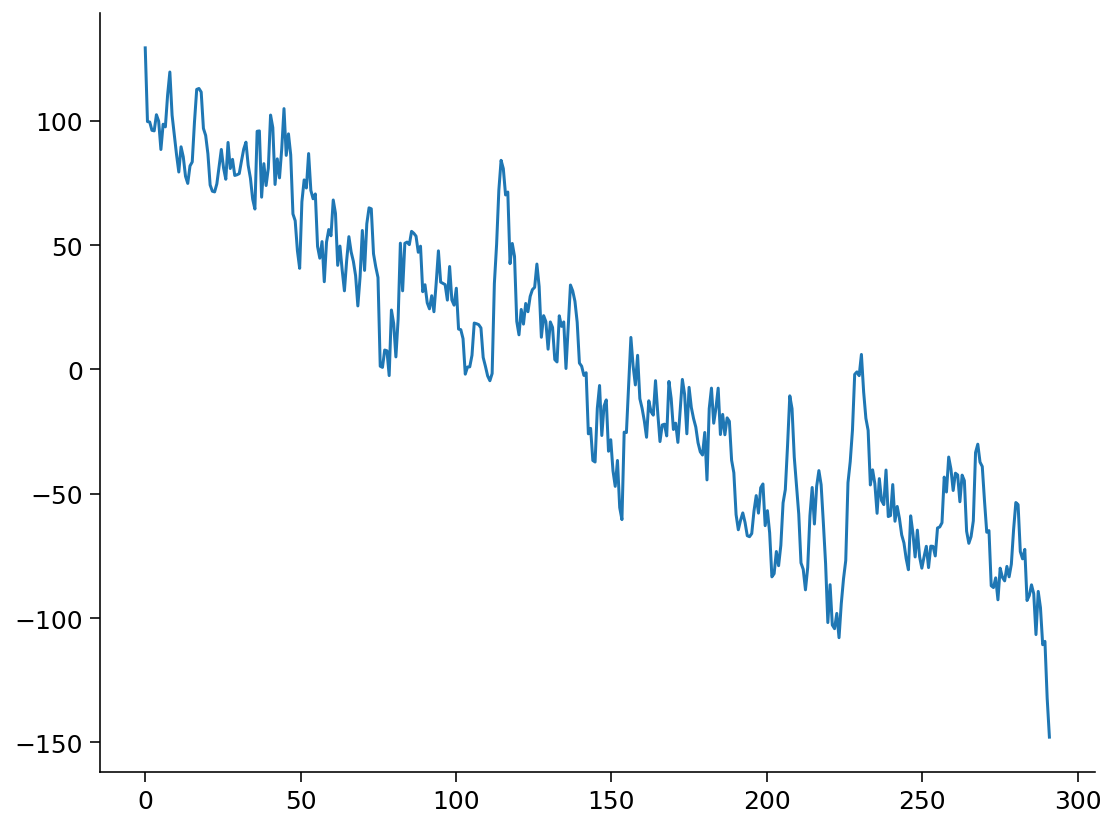

In [114]:
plt.plot(TR*np.arange(405),np.mean(load_single_timeseries(3, 'WM', 0)[:,:],axis=0).T);

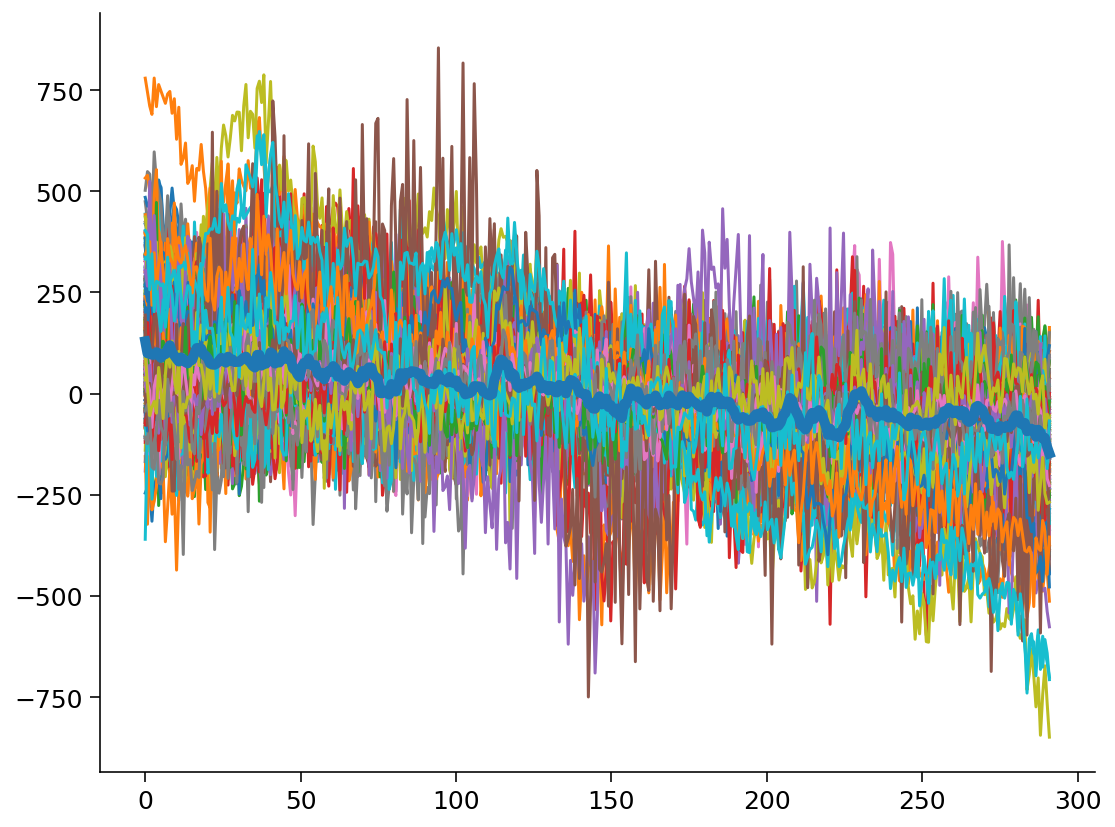

In [115]:
plt.plot(TR*np.arange(405),load_single_timeseries(3, 'WM', 0)[:,:].T);
plt.plot(TR*np.arange(405),np.mean(load_single_timeseries(3, 'WM', 0)[:,:],axis=0).T,linewidth=5);

[-0.12293858 24.8335926 ]


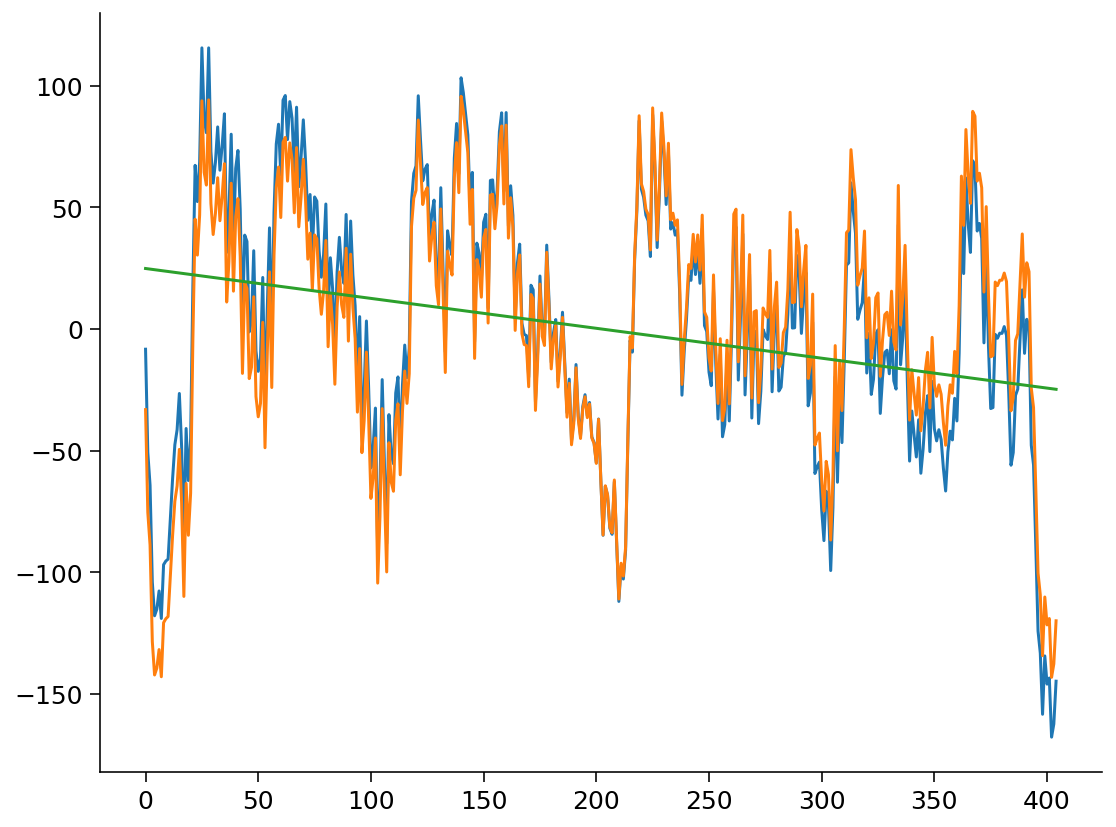

In [116]:
data = load_single_timeseries(subject=8,experiment='WM',run=0)
corrected_data, w = remove_drift(data)

print(w)
plt.plot(data[0, :].T)
plt.plot(corrected_data[0, :].T);
plt.plot(w[0] * np.arange(data.shape[1]) + w[1])

In [118]:
for task in evs.values():
  for cond in task.values():
    print(len(cond[0]))

39
39
39
39
39
39
39
39


In [119]:
def sliding_windows(timepoints, width = 20, stride = 1):
  return [timepoints[t:(t + 20)] for t in range(len(timepoints) - width)]

def get_corr_windows(data, windows):
  return np.stack([get_corr(data[:, ts]) for ts in windows])

def get_subj_corr_var(data, trange):
  sliding_corr = get_corr_windows(data, sliding_windows(trange))

  return np.var(sliding_corr, axis=0)

my_subj = 100
data = remove_drift(load_single_timeseries(my_subj, my_exp, my_run, remove_mean=True))[0]
rest_data = remove_drift(load_single_timeseries(my_subj, 'REST1', my_run, remove_mean=True))[0]
evs_2bk = load_task_data(my_subj, my_exp, my_run, '2bk', remove_mean=True)[1]
evs_0bk = load_task_data(my_subj, my_exp, my_run, '0bk', remove_mean=True)[1]
evs_wm = np.sort(np.concatenate((np.concatenate(tuple(evs_2bk.values())).flatten(), np.concatenate(tuple(evs_0bk.values())).flatten())))
trange = np.arange(evs_wm[0], evs_wm[-1])
windows = sliding_windows(trange)
sliding_corr = get_corr_windows(data, windows)
sliding_rest_corr = get_corr_windows(rest_data, sliding_windows(range(rest_data.shape[1])))
print(sliding_corr.shape)

(355, 360, 360)


In [ ]:
corr_var_time = map_across_trials(
    lambda data, rdata, evs, results: \
      get_subj_corr_var(np.squeeze(data[all_idxs, :]), trange),
    my_exp,
    SUBJECTS,
    remove_mean=True
)
rest_corr_var_time = map_across_trials(
    lambda data, rdata, evs, results: \
      get_subj_corr_var(np.squeeze(rdata[all_idxs, :]), range(rest_data.shape[1])),
    my_exp,
    SUBJECTS,
    remove_mean=True
)

In [ ]:
corr_var_diff_time = np.array([np.mean(corr_var_time[s] - rest_corr_var_time[s]) for s in SUBJECTS])

In [ ]:
print(corr_var_time.shape)

off_diag = np.triu_indices(corr_var_time.shape[0], k=1)
vmin = np.minimum(np.min(corr_var_time[off_diag]), np.min(rest_corr_var_time[off_diag]))
vmax = np.maximum(np.max(corr_var_time[off_diag]), np.max(rest_corr_var_time[off_diag]))
print(vmin)
print(vmax)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(corr_var_time, cmap='inferno', vmin = 0, vmax = vmax)
ax1.vlines(53, 0, 53)
ax1.hlines(53, 0, 53)
ax1.vlines(60, 0, 60)
ax1.hlines(60, 0, 60)
ax2.imshow(rest_corr_var_time, cmap='inferno', vmin = 0, vmax = vmax)
ax2.vlines(53, 0, 53)
ax2.hlines(53, 0, 53)
ax2.vlines(60, 0, 60)
ax2.hlines(60, 0, 60)

In [ ]:
plt.scatter(corr_var_diff_time, subj_accuracy)